In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


## Import model, tokenizer, and dataset

In [2]:
import datasets 
#load dataset
dataset = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')

# dataset = datasets.load_dataset("danielhou13/cogs402dataset2")

Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

#base model for training 
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)

# #importing local checkpoint
# model2 = LongformerForSequenceClassification.from_pretrained("models/longformer-finetuned/checkpoint-10000",num_labels=2)

#import same version from hub
model3 = LongformerForSequenceClassification.from_pretrained("danielhou13/longformer-finetuned-news-cogs402",num_labels=2)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
    validation: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
})


We then separate the two datasets

In [5]:
train_ds = dataset["train"]
eval_ds = dataset["validation"]

The Dataset is huge, so we take a subset of the data for both splits. Alternatively, if you have a split of the data stored on disk that you want to use for training, you can avoid using the following block of code.

In [6]:
## Take subset of data
train_size = 20000
val_size = 2500
import numpy as np

train_indices = np.random.randint(0, len(train_ds), train_size)
val_indices = np.random.randint(0, len(eval_ds), val_size)
train_ds = train_ds.select(train_indices)
eval_ds = eval_ds.select(val_indices)

In [6]:
# train_ds.save_to_disk("data/train_news")

We can import a training set or a validation set if you want to keep your data consistent by running the following command. Simply replace "data/train_news" with a path to your own data.

In [8]:
train_ds = datasets.load_from_disk("data/train_news")
print(train_ds)

Dataset({
    features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
    num_rows: 20000
})


Store the subset of data as a new dataset for reproducability

In [ ]:
# dataset["train"] = train_ds
# dataset["validation"] = val_ds
# print(dataset)

In [15]:
# upload this dataset to huggingface
# from huggingface_hub import notebook_login

# notebook_login()

In [37]:
# dataset.push_to_hub("danielhou13/cogs402dataset2")

Pushing split train to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split validation to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

## Exploratory Data Analysis

In [9]:
import pandas as pd

train_ds.set_format(type="pandas")
df = train_ds[:]
df["Words Per article"] = df["text"].str.split().apply(len)
df.head()

,text,title,hyperpartisan,url,published_at,bias,Words Per article
0,<p>US Treasury Secretary Timothy F. Geithner t...,Geithner defends his role in LIBOR-rigging sca...,False,https://pri.org/stories/2012-07-25/geithner-de...,2012-07-25,3,306
1,<p>.......... .......... .......... .............,"George Beall, who led prosecution of Vice Pres...",False,https://abqjournal.com/930680/george-beall-who...,,2,779
2,<p>Queen Elizabeth II is known to often times ...,The Queen Mother Is Almost Shot In Her Own Bac...,True,http://offthemainpage.com/2017/01/05/the-queen...,2017-01-05,4,180
3,<p>.......... .......... .......... .............,Rollover accident kills driver,False,https://abqjournal.com/535068/rollover-acciden...,,2,139
4,"<p>For the first time in American history, the...",HS Graduation Rate Hits Historic High. Obama C...,True,https://dailywire.com/news/10026/hs-graduation...,2016-10-18,0,373


We can see that by randomly selecting 20,000 examples from the training set, we still have a balanced dataset to train on

In [10]:
df["hyperpartisan"].value_counts(ascending=True)

False     9904
True     10096
Name: hyperpartisan, dtype: int64

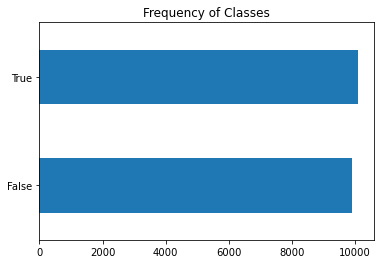

In [11]:
import matplotlib.pyplot as plt

df["hyperpartisan"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Lets find out the min, max and average number of words per article. The number of tokens would be higher but it gives us an estimate of the max number of tokens we want our tokenizer to operate on.

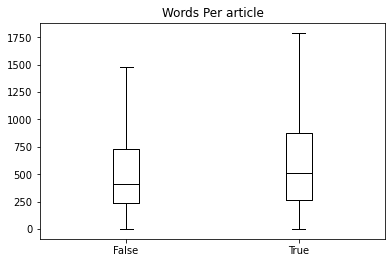

In [12]:
df.boxplot("Words Per article", by="hyperpartisan", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [13]:
train_ds.reset_format()

## Preprocessing

We need to convert the dataset into a pytorch compatible format so we need to change the target column's name into "labels"

In [14]:
#convert hyperpartisan to correct format (from true/false to 1/0)
labels = map(int, train_ds['hyperpartisan'])
labels = list(labels)

labels2 = map(int, eval_ds['hyperpartisan'])
labels2 = list(labels2)

In [15]:
#add the columns to the dataset
train_ds = train_ds.add_column("labels", labels)
eval_ds = eval_ds.add_column("labels", labels2)

Flattening the indices:   0%|          | 0/3 [00:00<?, ?ba/s]

We then tokenize the text in the dataset 

In [16]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [17]:
#tokenize the data
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = eval_ds.map(tokenize, load_from_cache_file=False)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Finally we change the columns we want into pytorch tensors and remove the unnecessary columns

In [18]:
#remove unnessesary columns and convert needed ones to torch format
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
val_dataset = val_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
print(train_dataset)


Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 20000
})


## Training

We train the 20,000 examples for 2 epochs and use gradient accumulation, gradient checkpointing and mixed precision in order to lower the memory requirements of the training.

In [19]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model3.to(device)
device

device(type='cuda')

In [21]:
#create checkpointing folder if doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

In [22]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) // gradient_acc
model_name = f"longformer-finetuned"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [23]:
print(logging_steps)

5000


We use f1-score and accuracy as fairly general metrics.

In [24]:
#create the metrics we want to find out, can import othe things like precision, recall if needed
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [25]:
trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)


In [26]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.304400,0.203822,0.954200,0.954171
2,0.144900,0.178321,0.966400,0.966400


TrainOutput(global_step=10000, training_loss=0.224652294921875, metrics={'train_runtime': 15993.7761, 'train_samples_per_second': 2.501, 'train_steps_per_second': 0.625, 'total_flos': 2.9076480813790464e+16, 'train_loss': 0.224652294921875, 'epoch': 2.0})

In [26]:
preds_output = trainer.predict(val_dataset)

## Results

In [27]:
preds_output.metrics

{'test_loss': 0.17283818125724792,
 'test_accuracy': 0.9696,
 'test_f1': 0.9696004669547587,
 'test_runtime': 234.8533,
 'test_samples_per_second': 10.645,
 'test_steps_per_second': 10.645}

In [28]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

In [29]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["false", "true"]
    )
)

              precision    recall  f1-score   support

       false       0.97      0.97      0.97      1240
        true       0.97      0.97      0.97      1260

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()



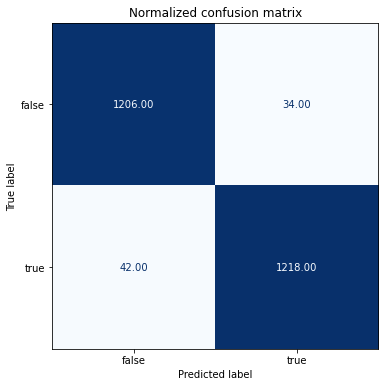

(2500,)
(2500,)


In [31]:
plot_confusion_matrix(y_preds, y_true, labels=["false", "true"])
print(y_true.shape)
print(y_preds.shape)

Trying on a larger evaluation set size (15000 vs 5000)

In [32]:
## Take subset of data
eval_ds = dataset["validation"]
val_size2 = 15000
val_indices2 = np.random.randint(0, len(eval_ds), val_size2)
val_ds2 = eval_ds.select(val_indices2)

In [33]:
labels3 = map(int, val_ds2['hyperpartisan'])
labels3 = list(labels3)

In [34]:
val_ds2 = val_ds2.add_column("labels", labels3)

Loading cached processed dataset at C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012\cache-9847eae9f30db4ec.arrow


In [35]:
val_dataset2 = val_ds2.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

In [36]:
#remove unnessesary columns and convert needed ones to torch format
val_dataset2.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset2 = val_dataset2.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])

In [37]:
preds_output2 = trainer.predict(val_dataset2)

In [38]:
y_preds2 = np.argmax(preds_output2.predictions, axis=1)
y_true2 = np.array(val_dataset2["labels"])

In [39]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true2, y_preds2, target_names=["false", "true"]
    )
)

              precision    recall  f1-score   support

       false       0.97      0.96      0.96      7498
        true       0.96      0.97      0.96      7502

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000



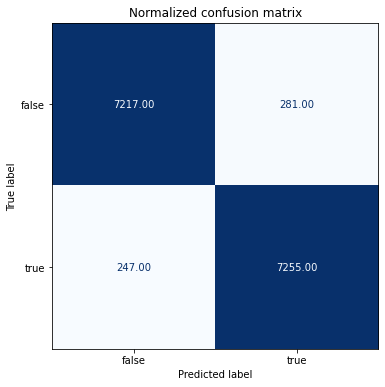

(15000,)
(15000,)


In [40]:
plot_confusion_matrix(y_preds2, y_true2, labels=["false", "true"])
print(y_true2.shape)
print(y_preds2.shape)

## Upload to huggingface

In [40]:
# from huggingface_hub import notebook_login

# notebook_login()

In [42]:
# # upload model to huggingface for storage
# # replace danielhou13 with personal user
# model.push_to_hub("danielhou13/longformer-finetuned-news-cogs402")

C:\Users\danie\miniconda3\lib\site-packages\huggingface_hub\hf_api.py:1001: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/danielhou13/longformer-finetuned-news-cogs402 into local empty directory.


Download file pytorch_model.bin:   0%|          | 2.83k/567M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/567M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 32.0k/567M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/danielhou13/longformer-finetuned-news-cogs402
   d4645d3..46dc639  main -> main



'https://huggingface.co/danielhou13/longformer-finetuned-news-cogs402/commit/46dc639baa796e9ad30abbfb37135e125582aad6'